In [1]:
## Try running simulations (starting all from one state) to get better idea of relaxations

import sys, pickle
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse


In [3]:
class seqObj:
    
    def __init__(self, seq, temp, state_list, nstates, nmodes, full_name , minflux=5e-6):
        
        self.seq = seq
        self.temp = temp
        self.state_list = state_list
        self.nstates = nstates
        self.nmodes = nmodes
        self.minflux = minflux
        self.full_name = full_name
        
        msm_path = '../MSM_construction/MSMs/'
        dist_path = '../dna_data/'
        self.meta_dir = f'{msm_path}{seq}_dist_reduced_{temp}K_40-250000-55_micro-200_macro-{nstates}_lag-12_srvlag-12/'
        self.dist_dir = f'{dist_path}{seq}_dist_{temp}K_40-250000-190.npy'
        
seq_dict = {}
seq_dict['AT-all'] =  seqObj(seq='AT-all', temp=309,
                      state_list=['3S4', '5S4', '3S2', '5S2', 'H', 'D'],
                      nstates= 6, nmodes = 5, minflux=5e-6, full_name= 'ATATATATAT')

seq_dict['GC-end'] =  seqObj(seq='GC-end', temp=317,
                      state_list=['5S4', '3S2', '5S2', 'D', 'H'], 
                      nstates= 5, nmodes = 5, minflux=5e-6, full_name= 'GATATATATC')

seq_dict['GC-core'] = seqObj(seq='GC-core', temp=324,
                      state_list=['F4', 'H', 'D'],
                      nstates= 3, nmodes = 3, minflux=5e-6, full_name= 'ATATGCATAT')

seq_dict['GC-mix'] = seqObj(seq='GC-mix', temp=324,
                      state_list=['H', 'D'],
                      nstates= 2, nmodes = 2, minflux=5e-6, full_name= 'ATGATATCAT')


In [4]:
# Scoring methods to track AT and GC responses

complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
fullseq_dict = {}

def score_all_cont(msm, seq, dtraj, dists, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign A:T and G:C scores by summing all availble contacts below respective cutoffs'''
    
    # find possible AT and GC pairs
    AT_possible, GC_possible = [], []
    dists = np.concatenate(dists)
    dtraj = np.concatenate(dtraj)

    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]

    idx = 0
    for b1 in s1_bps:
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
            
    print('AT len: ', len(AT_possible), 'GC len: ', len(GC_possible))

    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_possible], all_avgs[GC_possible]
        AT_score, GC_score = np.sum(AT_avgs<AT_cutoff), np.sum(GC_avgs<GC_cutoff)
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores

def score_native_dist(msm, seq, dtraj, dists, max_dist=1.0):
    '''assign continous score based on distance between all native wc contacts'''
    
    def score_dist(d):
        score = 2*(1-d)
        score[score < 0] = 0
        return score
        
    AT_wc, GC_wc = [], []
    dists = np.concatenate(dists)
    
    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]

    s1_idx = list(np.arange(len(seq)))
    s2_idx = [i for i in reversed(s1_idx)]
        
    idx = 0
    for b1, i1 in zip(s1_bps, s1_idx):
        for b2, i2 in zip(s2_bps, s2_idx):
            if i1==i2:
                if b1+b2 in ['AT', 'TA']:
                    AT_wc.append(idx)
                elif b1+b2 in ['GC', 'CG']:
                    GC_wc.append(idx)
            idx+=1
    
    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_wc], all_avgs[GC_wc]
        AT_score, GC_score = np.sum(score_dist(AT_avgs)), np.sum(score_dist(GC_avgs))
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores


In [5]:
# MSM simluations: assign each microstate an A:T and G:C score

AT_scores_list, GC_scores_list = [], []
seq_list, msm_list = [], []

for seq, seqObj in seq_dict.items():
    
    msm_path = seqObj.meta_dir + 'msm_hde.pkl'
    dtraj_path = seqObj.meta_dir + 'dtraj_hde.pkl'
    seq_full = seqObj.full_name
    
    msm = pickle.load(open(msm_path, 'rb'))
    dtraj = pickle.load(open(dtraj_path, 'rb'))
    dists = np.load(seqObj.dist_dir)[:, :, :100]
    #print(seq, seq_full, np.shape(dtraj), np.shape(dists))
    
    #AT_scores, GC_scores = score_native_dist(msm, seq_full, dtraj, dists)
    AT_scores, GC_scores = score_all_cont(msm, seq_full, dtraj, dists)
    AT_scores_list.append(np.array(AT_scores))
    GC_scores_list.append(np.array(GC_scores))
    seq_list.append(seq)
    msm_list.append(msm)


AT len:  50 GC len:  0
AT len:  32 GC len:  2
AT len:  32 GC len:  2
AT len:  32 GC len:  2


AT-all [[  2]
 [ 43]
 [172]] 200
(83334,) [10.          8.65080234  8.61552132 ...  4.29881411  4.29881411
  4.29881411]
GC-end [[  0]
 [ 28]
 [ 58]
 [ 65]
 [ 71]
 [ 99]
 [113]
 [123]
 [133]
 [134]
 [166]
 [171]
 [173]
 [181]
 [197]
 [198]] 200


/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


(83334,) [8.         7.95291243 7.93910505 ... 4.54650061 4.54650061 4.54650061]
GC-core [[ 42]
 [120]
 [126]
 [185]] 200
(83334,) [8.         6.41027151 6.234605   ... 2.81132942 2.81132942 2.81132942]
GC-mix [[  0]
 [ 42]
 [ 79]
 [109]
 [140]
 [156]
 [176]] 200
(83334,) [6.         5.68042915 5.66882034 ... 2.51778605 2.51778605 2.51778605]


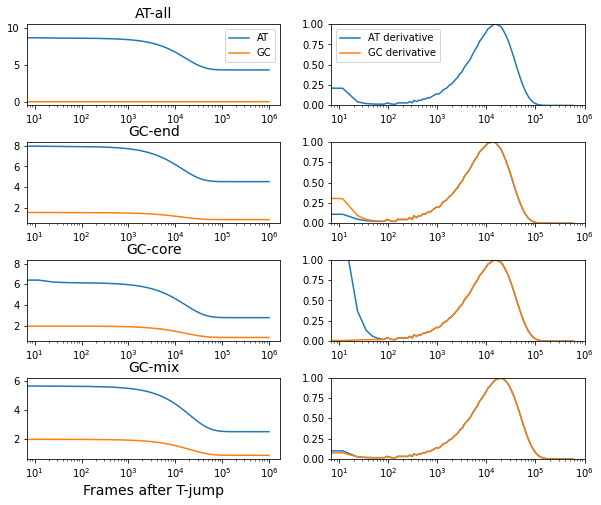

In [17]:
# relaxation experiments for AT and GC contributions

maxtime = 1e6
lag = 12
n_starts = 20

fsize = 14
max_logx = 11
#log_norm = np.exp(1)/np.exp()

def response_derivative(times, res):
    '''return a normlized discrete derivative of a given response'''
    
    exp_idxs = np.array([int(x) for x in np.exp(np.arange(0, max_logx, 0.1))])
    times_dx = np.array(sorted(set(exp_idxs)))-1
    res_dx = res[times_dx][1:] - res[times_dx][:-1]
    norm_dx = res_dx / np.min(res_dx[10:])
    return times_dx, norm_dx

fig, axes = plt.subplots(4, 2, figsize=(10, 8))
for seq, AT_scores, GC_scores, msm, ax_row in \
        zip(seq_list, AT_scores_list, GC_scores_list, msm_list, axes):
    
    # determine by most hybridized
    p0 = np.zeros(msm.nstates)
    combined_score = AT_scores+GC_scores
    most_hbr = np.argwhere(combined_score == np.amax(combined_score)) #np.argmax(combined_score)
    p0[most_hbr] = 1/len(most_hbr)
    #p0[most_hbr] = 1
    
    print(seq, most_hbr, len(p0))
    
    # run relaxation and plots
    times, AT_res = msm.relaxation(p0, AT_scores, maxtime=maxtime)
    _, GC_res = msm.relaxation(p0, GC_scores, maxtime=maxtime)
    print(np.shape(times), AT_res)
    
    # return derivatives
    times_dx, AT_dx = response_derivative(times, AT_res)
    _, GC_dx = response_derivative(times, GC_res)

    ax = ax_row[0]
    ax.plot(times, AT_res, label=f'AT')
    ax.plot(times, GC_res, label=f'GC')
    ax.set_xscale('log')
    if seq=='GC-mix': ax.set_xlabel('Frames after T-jump', fontsize=fsize)
    ax.set_title(seq, fontsize=fsize)
    
    # plot leading timescales
    label = 'leading implied timescales'
    for ts in msm.timescales(5):
        #ax.axvline(ts, linestyle='dashed', color='grey', label=label)
        label = ''
        
    ax = ax_row[1]
    ax.plot(times_dx[:-1]*lag, AT_dx, label=f'AT derivative')
    ax.plot(times_dx[:-1]*lag, GC_dx, label=f'GC derivative')
    ax.set_xscale('log')
    ax.set_ylim(0, 1)
        
plt.subplots_adjust(hspace=0.45)
axes[0, 0].legend()
axes[0, 1].legend()

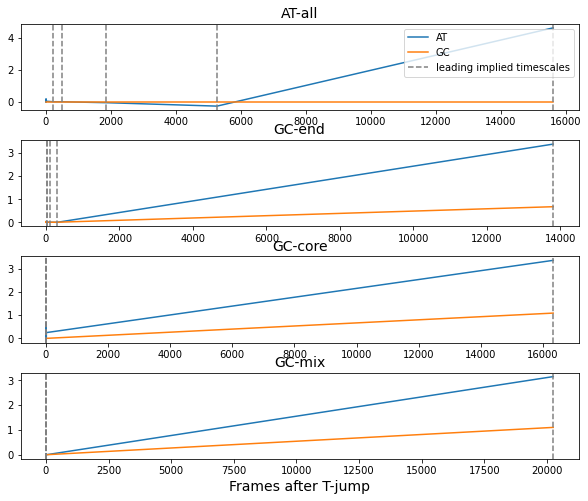

In [14]:
# try fingerprint relazation instead

maxtime = 1e6
lag = 12
n_starts = 20

fsize = 14

fig, axes = plt.subplots(4, 1, figsize=(10, 8))
for seq, AT_scores, GC_scores, msm, ax in \
        zip(seq_list, AT_scores_list, GC_scores_list, msm_list, axes):
    
    # determine by most hybridized
    p0 = np.zeros(msm.nstates)
    combined_score = AT_scores+GC_scores
    most_hbr = np.argwhere(combined_score == np.amax(combined_score)) #np.argmax(combined_score)
    p0[most_hbr] = 1/len(most_hbr)
    
    # run relaxation and plots
    times, AT_res = msm.fingerprint_relaxation(p0, AT_scores)
    _, GC_res = msm.fingerprint_relaxation(p0, GC_scores)
    
    ax.plot(times, AT_res, label=f'AT')
    ax.plot(times, GC_res, label=f'GC')
    #ax.set_xscale('log')
    if seq=='GC-mix': ax.set_xlabel('Frames after T-jump', fontsize=fsize)
    ax.set_title(seq, fontsize=fsize)
    
    # plot leading timescales
    label = 'leading implied timescales'
    for ts in msm.timescales(5):
        ax.axvline(ts, linestyle='dashed', color='grey', label=label)
        label = ''
        
plt.subplots_adjust(hspace=0.35)
axes[0].legend()